# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [43]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [44]:
# conda install matplotlib=2.0.2

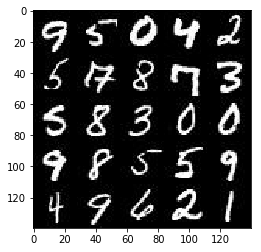

In [45]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

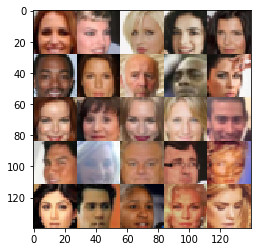

In [46]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [47]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [48]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs = tf.placeholder(tf.float32,(None, image_width,image_height,image_channels),name='inputs')
    input_z = tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    lr = tf.placeholder(tf.float32,name='lr')

    return inputs,input_z,lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [83]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator',reuse=reuse):
        conv2d_1 = tf.layers.conv2d(inputs=images, filters=32, kernel_size=3, strides=2, padding='same')
        act_1 = tf.maximum(0.1*conv2d_1, conv2d_1)
        
        conv2d_2 = tf.layers.conv2d(inputs=act_1, filters=64, kernel_size=3, strides=2, padding='same')
        bn_2 = tf.layers.batch_normalization(conv2d_2,training=True)
        act_2 = tf.maximum(0.1*bn_2, bn_2)
        
        conv2d_3 = tf.layers.conv2d(inputs=act_2, filters=128, kernel_size=3, strides=2, padding='same')
        bn_3 = tf.layers.batch_normalization(conv2d_3,training=True)
        act_3 = tf.maximum(0.1*bn_3, bn_3)
        
        conv2d_4 = tf.layers.conv2d(inputs=act_3, filters=256, kernel_size=3, strides=1, padding='same')
        bn_4 = tf.layers.batch_normalization(conv2d_4,training=True)
        act_4 = tf.maximum(0.1*bn_4, bn_4)
        
        flat = tf.reshape(act_4, (-1,4*4*512))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [84]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        
        z_1 = tf.layers.dense(z,7*7*256)
        z_1 = tf.reshape(z_1,(-1,7,7,256))
        bn_1 = tf.layers.batch_normalization(z_1,training=is_train)
        act_1 = tf.maximum(0.1*bn_1,bn_1)
        
        z_2 = tf.layers.conv2d_transpose(inputs=act_1,filters=128, kernel_size=3, strides=2, padding='same')
        bn_2 = tf.layers.batch_normalization(z_2,training=is_train)
        act_2 = tf.maximum(0.1*bn_2, bn_2)
                           
        z_3 = tf.layers.conv2d_transpose(inputs=act_2,filters=64, kernel_size=3, strides=2, padding='same')
        bn_3 = tf.layers.batch_normalization(z_3,training=is_train)
        act_3 = tf.maximum(0.1*bn_3, bn_3)
        
        z_4 = tf.layers.conv2d_transpose(inputs=act_3,filters=32, kernel_size=3, strides=1, padding='same')
        bn_4 = tf.layers.batch_normalization(z_4,training=is_train)
        act_4 = tf.maximum(0.1*bn_4, bn_4)
        
        logits = tf.layers.conv2d_transpose(inputs=act_4, filters=out_channel_dim,kernel_size=3,strides=1, padding='same')
        out = tf.tanh(logits)
    
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [87]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen = generator(input_z, out_channel_dim)
    d_out_real, d_logits_real = discriminator(input_real)
    d_out_fake, d_logits_fake = discriminator(gen, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(\
                                    logits=d_logits_real,labels=tf.ones_like(d_out_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(\
                                    logits=d_logits_fake,labels=tf.zeros_like(d_out_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(\
                                    logits=d_logits_fake,labels=tf.ones_like(d_out_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [77]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss,var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss,var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [78]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [79]:
def scale(x):   
    for i in range(x.shape[0]):
        maximum, minimum = np.amax(x[i,:,:]), np.amin(x[i,:,:,:])
        x[i,:,:,:] = 2.0 / (maximum - minimum) * x[i,:,:,:] - (maximum + minimum) / (maximum - minimum)
    return x


In [80]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2],data_shape[3],z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    losses = []
    
    steps= 0
    print_every=10
    show_every = 300
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = scale(batch_images) # range from (-1, 1)
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                sess.run(d_train_opt,feed_dict={input_real:batch_images, input_z:batch_z, lr:learning_rate})
                sess.run(g_train_opt,feed_dict={input_real:batch_images, input_z:batch_z, lr:learning_rate})
                
                if steps % print_every == 0:
                    d_train_loss = d_loss.eval(feed_dict={input_real:batch_images, input_z:batch_z})
                    g_train_loss = g_loss.eval(feed_dict={input_z:batch_z})
                    print("Epoch {}/{}".format(epoch_i+1,epochs),\
                         "  Discriminator Loss: {:.4f}".format(d_train_loss),\
                         "  Generator Loss: {:.4f}".format(g_train_loss))
                    losses.append((d_train_loss, g_train_loss))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2   Discriminator Loss: 1.4173   Generator Loss: 0.3434
Epoch 1/2   Discriminator Loss: 0.6222   Generator Loss: 0.9624
Epoch 1/2   Discriminator Loss: 1.1067   Generator Loss: 0.7132
Epoch 1/2   Discriminator Loss: 2.1467   Generator Loss: 4.5025
Epoch 1/2   Discriminator Loss: 1.4043   Generator Loss: 2.5699
Epoch 1/2   Discriminator Loss: 1.2743   Generator Loss: 1.4890
Epoch 1/2   Discriminator Loss: 1.3245   Generator Loss: 1.5094
Epoch 1/2   Discriminator Loss: 1.3147   Generator Loss: 0.9701
Epoch 1/2   Discriminator Loss: 1.1149   Generator Loss: 1.2842
Epoch 1/2   Discriminator Loss: 1.2918   Generator Loss: 1.2864
Epoch 1/2   Discriminator Loss: 1.1519   Generator Loss: 0.8531
Epoch 1/2   Discriminator Loss: 1.1863   Generator Loss: 0.7908
Epoch 1/2   Discriminator Loss: 1.3664   Generator Loss: 1.4541
Epoch 1/2   Discriminator Loss: 1.2742   Generator Loss: 1.2781
Epoch 1/2   Discriminator Loss: 1.5256   Generator Loss: 1.3774
Epoch 1/2   Discriminator Loss: 1.1108  

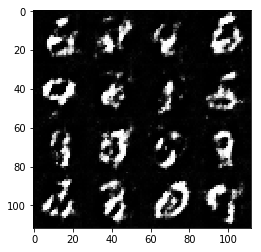

Epoch 1/2   Discriminator Loss: 0.8898   Generator Loss: 1.1115
Epoch 1/2   Discriminator Loss: 0.9221   Generator Loss: 1.9386
Epoch 1/2   Discriminator Loss: 0.6911   Generator Loss: 1.2148
Epoch 1/2   Discriminator Loss: 0.8560   Generator Loss: 0.8200
Epoch 1/2   Discriminator Loss: 0.8751   Generator Loss: 1.8285
Epoch 1/2   Discriminator Loss: 1.0984   Generator Loss: 0.5801
Epoch 1/2   Discriminator Loss: 1.3591   Generator Loss: 0.4093
Epoch 1/2   Discriminator Loss: 1.1262   Generator Loss: 0.5384
Epoch 1/2   Discriminator Loss: 1.3175   Generator Loss: 0.4029
Epoch 1/2   Discriminator Loss: 1.5949   Generator Loss: 0.2767
Epoch 1/2   Discriminator Loss: 0.8973   Generator Loss: 1.7266
Epoch 1/2   Discriminator Loss: 0.7827   Generator Loss: 1.1675
Epoch 1/2   Discriminator Loss: 1.2803   Generator Loss: 2.4133
Epoch 1/2   Discriminator Loss: 1.0290   Generator Loss: 0.6246
Epoch 1/2   Discriminator Loss: 1.8433   Generator Loss: 0.2010
Epoch 1/2   Discriminator Loss: 1.5190  

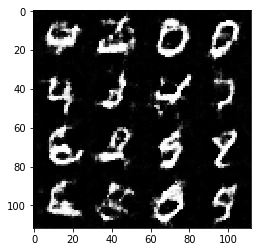

Epoch 2/2   Discriminator Loss: 1.5776   Generator Loss: 0.2949
Epoch 2/2   Discriminator Loss: 1.1977   Generator Loss: 0.5704
Epoch 2/2   Discriminator Loss: 1.1607   Generator Loss: 0.5433
Epoch 2/2   Discriminator Loss: 1.5329   Generator Loss: 0.3026
Epoch 2/2   Discriminator Loss: 1.2891   Generator Loss: 0.4401
Epoch 2/2   Discriminator Loss: 1.3203   Generator Loss: 0.4134
Epoch 2/2   Discriminator Loss: 1.0181   Generator Loss: 0.7207
Epoch 2/2   Discriminator Loss: 1.0901   Generator Loss: 1.5639
Epoch 2/2   Discriminator Loss: 0.9625   Generator Loss: 1.0720
Epoch 2/2   Discriminator Loss: 0.9840   Generator Loss: 0.9840
Epoch 2/2   Discriminator Loss: 0.9940   Generator Loss: 1.2372
Epoch 2/2   Discriminator Loss: 0.9679   Generator Loss: 1.3234
Epoch 2/2   Discriminator Loss: 1.0524   Generator Loss: 1.1411
Epoch 2/2   Discriminator Loss: 0.8056   Generator Loss: 1.1862
Epoch 2/2   Discriminator Loss: 1.7256   Generator Loss: 0.2453
Epoch 2/2   Discriminator Loss: 0.9802  

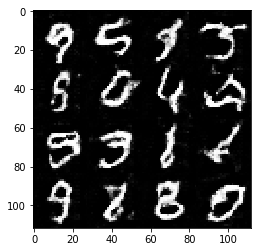

Epoch 2/2   Discriminator Loss: 1.4406   Generator Loss: 0.3455
Epoch 2/2   Discriminator Loss: 1.1519   Generator Loss: 0.5264
Epoch 2/2   Discriminator Loss: 0.9350   Generator Loss: 1.0002


In [92]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

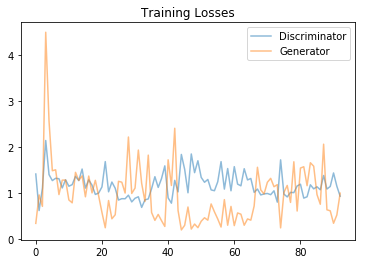

In [93]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/4   Discriminator Loss: 0.6416   Generator Loss: 1.3244
Epoch 1/4   Discriminator Loss: 3.8971   Generator Loss: 6.8712
Epoch 1/4   Discriminator Loss: 1.9137   Generator Loss: 1.6566
Epoch 1/4   Discriminator Loss: 1.5777   Generator Loss: 2.4728
Epoch 1/4   Discriminator Loss: 1.3744   Generator Loss: 1.7530
Epoch 1/4   Discriminator Loss: 1.5248   Generator Loss: 2.0328
Epoch 1/4   Discriminator Loss: 1.3123   Generator Loss: 1.8367
Epoch 1/4   Discriminator Loss: 1.8290   Generator Loss: 1.6091
Epoch 1/4   Discriminator Loss: 1.4730   Generator Loss: 1.5203
Epoch 1/4   Discriminator Loss: 1.9077   Generator Loss: 2.5208
Epoch 1/4   Discriminator Loss: 1.7172   Generator Loss: 1.3689
Epoch 1/4   Discriminator Loss: 1.3908   Generator Loss: 1.1857
Epoch 1/4   Discriminator Loss: 1.6837   Generator Loss: 0.9568
Epoch 1/4   Discriminator Loss: 1.7255   Generator Loss: 1.2880
Epoch 1/4   Discriminator Loss: 1.9882   Generator Loss: 0.1956
Epoch 1/4   Discriminator Loss: 1.4020  

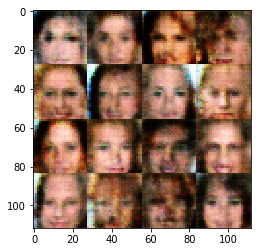

Epoch 1/4   Discriminator Loss: 1.5513   Generator Loss: 0.3479
Epoch 1/4   Discriminator Loss: 1.7028   Generator Loss: 0.2715
Epoch 1/4   Discriminator Loss: 1.6142   Generator Loss: 0.3361
Epoch 1/4   Discriminator Loss: 1.4699   Generator Loss: 0.4244
Epoch 1/4   Discriminator Loss: 1.7758   Generator Loss: 0.2612
Epoch 1/4   Discriminator Loss: 1.0661   Generator Loss: 0.9305
Epoch 1/4   Discriminator Loss: 1.3936   Generator Loss: 0.6674
Epoch 1/4   Discriminator Loss: 1.3011   Generator Loss: 1.0857
Epoch 1/4   Discriminator Loss: 1.4314   Generator Loss: 0.4158
Epoch 1/4   Discriminator Loss: 1.7739   Generator Loss: 0.2580
Epoch 1/4   Discriminator Loss: 1.2071   Generator Loss: 0.6635
Epoch 1/4   Discriminator Loss: 1.7078   Generator Loss: 0.2878
Epoch 1/4   Discriminator Loss: 1.6469   Generator Loss: 0.2874
Epoch 1/4   Discriminator Loss: 1.8358   Generator Loss: 0.2237
Epoch 1/4   Discriminator Loss: 1.6623   Generator Loss: 0.2948
Epoch 1/4   Discriminator Loss: 1.9680  

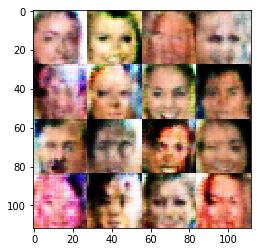

Epoch 1/4   Discriminator Loss: 1.6504   Generator Loss: 0.3958
Epoch 1/4   Discriminator Loss: 1.5436   Generator Loss: 0.6226
Epoch 1/4   Discriminator Loss: 1.2875   Generator Loss: 0.7391
Epoch 1/4   Discriminator Loss: 1.3571   Generator Loss: 0.6841
Epoch 1/4   Discriminator Loss: 1.4265   Generator Loss: 0.5255
Epoch 1/4   Discriminator Loss: 1.6008   Generator Loss: 1.3572
Epoch 1/4   Discriminator Loss: 1.4180   Generator Loss: 1.2369
Epoch 1/4   Discriminator Loss: 1.7007   Generator Loss: 0.3358
Epoch 1/4   Discriminator Loss: 1.2103   Generator Loss: 0.7222
Epoch 1/4   Discriminator Loss: 1.8174   Generator Loss: 0.2197
Epoch 1/4   Discriminator Loss: 1.6853   Generator Loss: 1.1311
Epoch 1/4   Discriminator Loss: 1.5085   Generator Loss: 1.0738
Epoch 1/4   Discriminator Loss: 1.4168   Generator Loss: 0.7800
Epoch 1/4   Discriminator Loss: 1.5368   Generator Loss: 0.7572
Epoch 1/4   Discriminator Loss: 1.3990   Generator Loss: 0.9351
Epoch 1/4   Discriminator Loss: 1.8726  

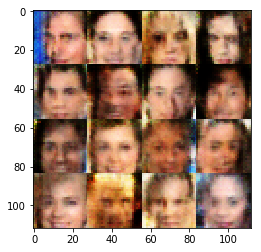

Epoch 1/4   Discriminator Loss: 1.3101   Generator Loss: 0.5182
Epoch 1/4   Discriminator Loss: 1.3516   Generator Loss: 0.5030
Epoch 1/4   Discriminator Loss: 1.7009   Generator Loss: 0.2614
Epoch 1/4   Discriminator Loss: 1.2581   Generator Loss: 0.6147
Epoch 1/4   Discriminator Loss: 1.3645   Generator Loss: 0.6513
Epoch 1/4   Discriminator Loss: 1.1019   Generator Loss: 0.8868
Epoch 1/4   Discriminator Loss: 1.4706   Generator Loss: 1.6501
Epoch 1/4   Discriminator Loss: 1.4290   Generator Loss: 0.5431
Epoch 1/4   Discriminator Loss: 1.2693   Generator Loss: 0.8097
Epoch 1/4   Discriminator Loss: 1.0616   Generator Loss: 0.6180
Epoch 1/4   Discriminator Loss: 1.7466   Generator Loss: 0.2854
Epoch 1/4   Discriminator Loss: 1.2781   Generator Loss: 0.6938
Epoch 1/4   Discriminator Loss: 1.3143   Generator Loss: 0.4954
Epoch 1/4   Discriminator Loss: 1.4492   Generator Loss: 0.9700
Epoch 1/4   Discriminator Loss: 1.5626   Generator Loss: 0.3588
Epoch 1/4   Discriminator Loss: 1.4250  

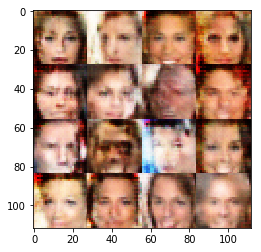

Epoch 1/4   Discriminator Loss: 1.5603   Generator Loss: 0.4336
Epoch 1/4   Discriminator Loss: 1.3407   Generator Loss: 0.5848
Epoch 1/4   Discriminator Loss: 1.4503   Generator Loss: 0.3615
Epoch 1/4   Discriminator Loss: 1.3487   Generator Loss: 0.6976
Epoch 1/4   Discriminator Loss: 1.3757   Generator Loss: 1.4965
Epoch 1/4   Discriminator Loss: 1.4666   Generator Loss: 0.5559
Epoch 1/4   Discriminator Loss: 1.2990   Generator Loss: 0.5460
Epoch 1/4   Discriminator Loss: 1.2950   Generator Loss: 0.5102
Epoch 1/4   Discriminator Loss: 1.4555   Generator Loss: 0.9179
Epoch 1/4   Discriminator Loss: 1.3562   Generator Loss: 0.7636
Epoch 1/4   Discriminator Loss: 1.2775   Generator Loss: 0.5935
Epoch 1/4   Discriminator Loss: 1.3256   Generator Loss: 1.0982
Epoch 1/4   Discriminator Loss: 1.1537   Generator Loss: 0.8981
Epoch 1/4   Discriminator Loss: 1.4574   Generator Loss: 0.4446
Epoch 1/4   Discriminator Loss: 1.7078   Generator Loss: 1.6090
Epoch 1/4   Discriminator Loss: 1.3587  

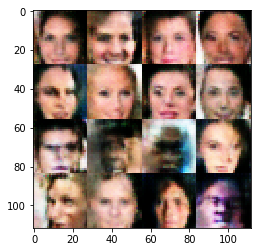

Epoch 1/4   Discriminator Loss: 1.7324   Generator Loss: 0.2415
Epoch 1/4   Discriminator Loss: 1.2936   Generator Loss: 0.5896
Epoch 1/4   Discriminator Loss: 1.6332   Generator Loss: 0.2760
Epoch 1/4   Discriminator Loss: 1.2069   Generator Loss: 0.6983
Epoch 1/4   Discriminator Loss: 1.2547   Generator Loss: 0.8774
Epoch 1/4   Discriminator Loss: 2.0127   Generator Loss: 0.1872
Epoch 1/4   Discriminator Loss: 1.3004   Generator Loss: 0.5288
Epoch 1/4   Discriminator Loss: 1.3789   Generator Loss: 0.4245
Epoch 2/4   Discriminator Loss: 1.2515   Generator Loss: 0.7814
Epoch 2/4   Discriminator Loss: 1.2805   Generator Loss: 0.6075
Epoch 2/4   Discriminator Loss: 1.2985   Generator Loss: 0.6624
Epoch 2/4   Discriminator Loss: 1.8098   Generator Loss: 0.2878
Epoch 2/4   Discriminator Loss: 1.4155   Generator Loss: 0.6850
Epoch 2/4   Discriminator Loss: 1.2968   Generator Loss: 0.5744
Epoch 2/4   Discriminator Loss: 1.3902   Generator Loss: 0.4753
Epoch 2/4   Discriminator Loss: 1.2366  

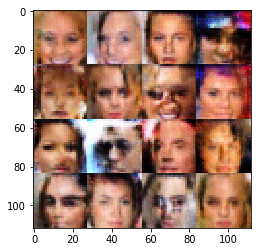

Epoch 2/4   Discriminator Loss: 0.9885   Generator Loss: 0.7087
Epoch 2/4   Discriminator Loss: 1.3470   Generator Loss: 0.4797
Epoch 2/4   Discriminator Loss: 1.5831   Generator Loss: 0.4512
Epoch 2/4   Discriminator Loss: 1.1620   Generator Loss: 0.8223
Epoch 2/4   Discriminator Loss: 1.2100   Generator Loss: 0.5593
Epoch 2/4   Discriminator Loss: 1.3828   Generator Loss: 0.5495
Epoch 2/4   Discriminator Loss: 0.9316   Generator Loss: 0.6701
Epoch 2/4   Discriminator Loss: 1.4874   Generator Loss: 0.9003
Epoch 2/4   Discriminator Loss: 1.4058   Generator Loss: 0.5967
Epoch 2/4   Discriminator Loss: 1.0788   Generator Loss: 0.7111
Epoch 2/4   Discriminator Loss: 1.4125   Generator Loss: 0.6041
Epoch 2/4   Discriminator Loss: 1.3043   Generator Loss: 0.5134
Epoch 2/4   Discriminator Loss: 1.3243   Generator Loss: 0.7834
Epoch 2/4   Discriminator Loss: 1.3281   Generator Loss: 0.6037
Epoch 2/4   Discriminator Loss: 1.2949   Generator Loss: 0.5802
Epoch 2/4   Discriminator Loss: 1.4154  

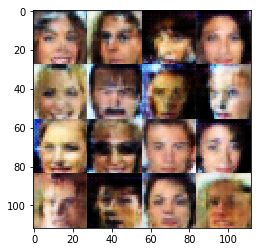

Epoch 2/4   Discriminator Loss: 1.2895   Generator Loss: 0.7141
Epoch 2/4   Discriminator Loss: 1.1411   Generator Loss: 0.7929
Epoch 2/4   Discriminator Loss: 1.2785   Generator Loss: 0.4699
Epoch 2/4   Discriminator Loss: 1.2523   Generator Loss: 0.5687
Epoch 2/4   Discriminator Loss: 1.5666   Generator Loss: 0.4483
Epoch 2/4   Discriminator Loss: 1.2197   Generator Loss: 0.6643
Epoch 2/4   Discriminator Loss: 1.4327   Generator Loss: 0.4230
Epoch 2/4   Discriminator Loss: 1.4890   Generator Loss: 0.5101
Epoch 2/4   Discriminator Loss: 1.6012   Generator Loss: 1.3923
Epoch 2/4   Discriminator Loss: 1.3053   Generator Loss: 0.6503
Epoch 2/4   Discriminator Loss: 1.2231   Generator Loss: 0.7896
Epoch 2/4   Discriminator Loss: 1.2024   Generator Loss: 0.8928
Epoch 2/4   Discriminator Loss: 1.2671   Generator Loss: 0.7114
Epoch 2/4   Discriminator Loss: 1.1655   Generator Loss: 0.7364
Epoch 2/4   Discriminator Loss: 1.4671   Generator Loss: 0.4260
Epoch 2/4   Discriminator Loss: 1.1429  

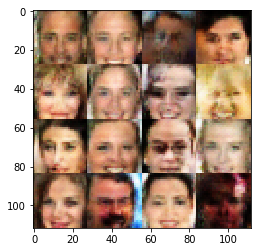

Epoch 2/4   Discriminator Loss: 2.1147   Generator Loss: 0.1533
Epoch 2/4   Discriminator Loss: 1.1809   Generator Loss: 0.6908
Epoch 2/4   Discriminator Loss: 1.3592   Generator Loss: 0.5608
Epoch 2/4   Discriminator Loss: 1.2664   Generator Loss: 0.6462
Epoch 2/4   Discriminator Loss: 1.2065   Generator Loss: 0.5761
Epoch 2/4   Discriminator Loss: 1.2052   Generator Loss: 0.7198
Epoch 2/4   Discriminator Loss: 1.4030   Generator Loss: 0.5574
Epoch 2/4   Discriminator Loss: 1.3053   Generator Loss: 0.4889
Epoch 2/4   Discriminator Loss: 1.2396   Generator Loss: 0.4979
Epoch 2/4   Discriminator Loss: 1.3041   Generator Loss: 0.5479
Epoch 2/4   Discriminator Loss: 1.3970   Generator Loss: 0.5034
Epoch 2/4   Discriminator Loss: 1.2999   Generator Loss: 0.4610
Epoch 2/4   Discriminator Loss: 1.3374   Generator Loss: 1.2049
Epoch 2/4   Discriminator Loss: 1.2515   Generator Loss: 0.5210
Epoch 2/4   Discriminator Loss: 1.3238   Generator Loss: 0.7508
Epoch 2/4   Discriminator Loss: 1.3914  

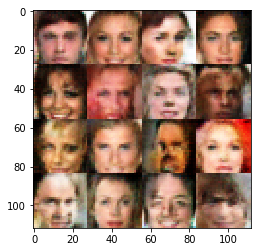

Epoch 2/4   Discriminator Loss: 1.4713   Generator Loss: 0.5541
Epoch 2/4   Discriminator Loss: 1.2302   Generator Loss: 0.8333
Epoch 2/4   Discriminator Loss: 1.3904   Generator Loss: 0.8728
Epoch 2/4   Discriminator Loss: 1.4582   Generator Loss: 0.4905
Epoch 2/4   Discriminator Loss: 1.2295   Generator Loss: 0.5472
Epoch 2/4   Discriminator Loss: 1.1459   Generator Loss: 0.5847
Epoch 2/4   Discriminator Loss: 1.5281   Generator Loss: 0.3872
Epoch 2/4   Discriminator Loss: 1.1568   Generator Loss: 0.8390
Epoch 2/4   Discriminator Loss: 1.3172   Generator Loss: 0.8240
Epoch 2/4   Discriminator Loss: 1.2987   Generator Loss: 0.5228
Epoch 2/4   Discriminator Loss: 1.1815   Generator Loss: 0.6690
Epoch 2/4   Discriminator Loss: 1.2897   Generator Loss: 0.6461
Epoch 2/4   Discriminator Loss: 1.2847   Generator Loss: 0.7444
Epoch 2/4   Discriminator Loss: 1.3800   Generator Loss: 0.4533
Epoch 2/4   Discriminator Loss: 1.3009   Generator Loss: 0.4550
Epoch 2/4   Discriminator Loss: 1.3064  

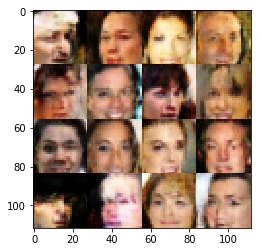

Epoch 2/4   Discriminator Loss: 1.2306   Generator Loss: 0.5372
Epoch 2/4   Discriminator Loss: 1.3714   Generator Loss: 0.6780
Epoch 2/4   Discriminator Loss: 1.2691   Generator Loss: 0.4670
Epoch 2/4   Discriminator Loss: 1.3652   Generator Loss: 0.5448
Epoch 2/4   Discriminator Loss: 1.5070   Generator Loss: 0.4039
Epoch 2/4   Discriminator Loss: 1.2709   Generator Loss: 0.7772
Epoch 2/4   Discriminator Loss: 1.3292   Generator Loss: 0.6360
Epoch 2/4   Discriminator Loss: 1.2627   Generator Loss: 0.7542
Epoch 2/4   Discriminator Loss: 1.6016   Generator Loss: 0.3547
Epoch 2/4   Discriminator Loss: 1.3513   Generator Loss: 0.5090
Epoch 2/4   Discriminator Loss: 1.2986   Generator Loss: 0.7840
Epoch 2/4   Discriminator Loss: 1.3086   Generator Loss: 0.7309
Epoch 2/4   Discriminator Loss: 1.4527   Generator Loss: 0.8923
Epoch 2/4   Discriminator Loss: 1.1945   Generator Loss: 0.4536
Epoch 2/4   Discriminator Loss: 1.4161   Generator Loss: 0.4256
Epoch 2/4   Discriminator Loss: 1.0523  

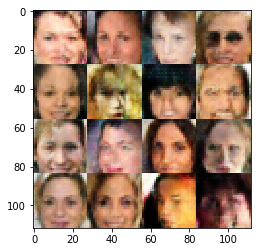

Epoch 3/4   Discriminator Loss: 1.3369   Generator Loss: 0.5645
Epoch 3/4   Discriminator Loss: 1.4347   Generator Loss: 0.4015
Epoch 3/4   Discriminator Loss: 1.3942   Generator Loss: 0.7987
Epoch 3/4   Discriminator Loss: 1.5165   Generator Loss: 1.2376
Epoch 3/4   Discriminator Loss: 1.3917   Generator Loss: 0.5787
Epoch 3/4   Discriminator Loss: 1.2320   Generator Loss: 0.7999
Epoch 3/4   Discriminator Loss: 1.5885   Generator Loss: 0.9660
Epoch 3/4   Discriminator Loss: 1.3619   Generator Loss: 0.7676
Epoch 3/4   Discriminator Loss: 1.4927   Generator Loss: 0.5309
Epoch 3/4   Discriminator Loss: 1.3452   Generator Loss: 0.8948
Epoch 3/4   Discriminator Loss: 1.2275   Generator Loss: 0.4983
Epoch 3/4   Discriminator Loss: 1.4633   Generator Loss: 0.6026
Epoch 3/4   Discriminator Loss: 1.3915   Generator Loss: 0.4999
Epoch 3/4   Discriminator Loss: 1.1668   Generator Loss: 0.5600
Epoch 3/4   Discriminator Loss: 1.3721   Generator Loss: 0.5231
Epoch 3/4   Discriminator Loss: 0.9448  

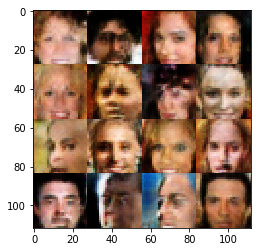

Epoch 3/4   Discriminator Loss: 1.5065   Generator Loss: 0.6413
Epoch 3/4   Discriminator Loss: 1.4636   Generator Loss: 0.4211
Epoch 3/4   Discriminator Loss: 1.4131   Generator Loss: 0.6991
Epoch 3/4   Discriminator Loss: 1.3441   Generator Loss: 0.5799
Epoch 3/4   Discriminator Loss: 1.2828   Generator Loss: 0.8512
Epoch 3/4   Discriminator Loss: 1.4324   Generator Loss: 0.6823
Epoch 3/4   Discriminator Loss: 1.4486   Generator Loss: 1.2014
Epoch 3/4   Discriminator Loss: 1.3493   Generator Loss: 0.6171
Epoch 3/4   Discriminator Loss: 1.3043   Generator Loss: 0.5922
Epoch 3/4   Discriminator Loss: 1.4910   Generator Loss: 0.4227
Epoch 3/4   Discriminator Loss: 1.5395   Generator Loss: 0.4278
Epoch 3/4   Discriminator Loss: 1.2705   Generator Loss: 0.5922
Epoch 3/4   Discriminator Loss: 1.7281   Generator Loss: 0.2786
Epoch 3/4   Discriminator Loss: 1.3657   Generator Loss: 0.7190
Epoch 3/4   Discriminator Loss: 1.5202   Generator Loss: 0.9339
Epoch 3/4   Discriminator Loss: 1.4780  

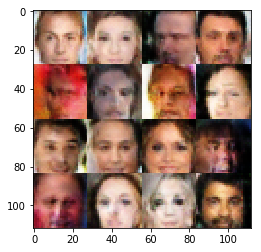

Epoch 3/4   Discriminator Loss: 1.2526   Generator Loss: 0.5941
Epoch 3/4   Discriminator Loss: 1.4234   Generator Loss: 0.3946
Epoch 3/4   Discriminator Loss: 1.4589   Generator Loss: 0.6422
Epoch 3/4   Discriminator Loss: 1.2323   Generator Loss: 0.5983
Epoch 3/4   Discriminator Loss: 1.4470   Generator Loss: 0.6206
Epoch 3/4   Discriminator Loss: 1.1265   Generator Loss: 0.7685
Epoch 3/4   Discriminator Loss: 1.5094   Generator Loss: 0.5003
Epoch 3/4   Discriminator Loss: 1.4483   Generator Loss: 0.5041
Epoch 3/4   Discriminator Loss: 1.3635   Generator Loss: 0.4760
Epoch 3/4   Discriminator Loss: 1.4107   Generator Loss: 0.8112
Epoch 3/4   Discriminator Loss: 1.3419   Generator Loss: 0.6676
Epoch 3/4   Discriminator Loss: 1.4317   Generator Loss: 0.5445
Epoch 3/4   Discriminator Loss: 1.4048   Generator Loss: 0.4657
Epoch 3/4   Discriminator Loss: 1.3641   Generator Loss: 0.9343
Epoch 3/4   Discriminator Loss: 1.2612   Generator Loss: 0.7131
Epoch 3/4   Discriminator Loss: 1.6221  

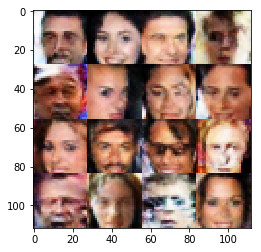

Epoch 3/4   Discriminator Loss: 1.3605   Generator Loss: 0.7484
Epoch 3/4   Discriminator Loss: 1.2983   Generator Loss: 0.6504
Epoch 3/4   Discriminator Loss: 1.2172   Generator Loss: 0.5767
Epoch 3/4   Discriminator Loss: 1.2668   Generator Loss: 0.9273
Epoch 3/4   Discriminator Loss: 1.5419   Generator Loss: 0.5723
Epoch 3/4   Discriminator Loss: 1.3678   Generator Loss: 0.5828
Epoch 3/4   Discriminator Loss: 1.4772   Generator Loss: 0.3959
Epoch 3/4   Discriminator Loss: 1.4734   Generator Loss: 0.4502
Epoch 3/4   Discriminator Loss: 1.6406   Generator Loss: 0.3019
Epoch 3/4   Discriminator Loss: 1.2810   Generator Loss: 0.6553
Epoch 3/4   Discriminator Loss: 1.3805   Generator Loss: 0.6191
Epoch 3/4   Discriminator Loss: 1.4054   Generator Loss: 0.4698
Epoch 3/4   Discriminator Loss: 1.3852   Generator Loss: 0.5281
Epoch 3/4   Discriminator Loss: 1.2872   Generator Loss: 0.6880
Epoch 3/4   Discriminator Loss: 1.3799   Generator Loss: 0.4905
Epoch 3/4   Discriminator Loss: 1.3849  

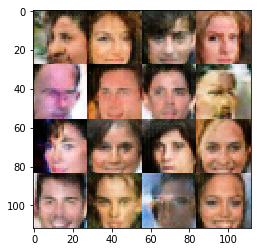

Epoch 3/4   Discriminator Loss: 1.4382   Generator Loss: 0.4453
Epoch 3/4   Discriminator Loss: 1.3408   Generator Loss: 0.5815
Epoch 3/4   Discriminator Loss: 1.5555   Generator Loss: 0.5020
Epoch 3/4   Discriminator Loss: 1.3002   Generator Loss: 0.8567
Epoch 3/4   Discriminator Loss: 1.3643   Generator Loss: 0.4059
Epoch 3/4   Discriminator Loss: 1.5799   Generator Loss: 1.1281
Epoch 3/4   Discriminator Loss: 1.5974   Generator Loss: 0.2951
Epoch 3/4   Discriminator Loss: 1.2747   Generator Loss: 0.5418
Epoch 3/4   Discriminator Loss: 1.3048   Generator Loss: 0.6665
Epoch 3/4   Discriminator Loss: 1.3073   Generator Loss: 0.4627
Epoch 3/4   Discriminator Loss: 1.4249   Generator Loss: 0.9826
Epoch 3/4   Discriminator Loss: 1.2678   Generator Loss: 0.6234
Epoch 3/4   Discriminator Loss: 1.5062   Generator Loss: 0.3306
Epoch 3/4   Discriminator Loss: 1.4257   Generator Loss: 0.5102
Epoch 3/4   Discriminator Loss: 1.1924   Generator Loss: 0.5701
Epoch 3/4   Discriminator Loss: 1.2884  

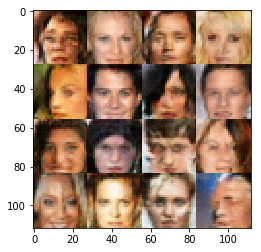

Epoch 4/4   Discriminator Loss: 1.5413   Generator Loss: 0.3038
Epoch 4/4   Discriminator Loss: 1.2816   Generator Loss: 0.5274
Epoch 4/4   Discriminator Loss: 1.3251   Generator Loss: 0.5072
Epoch 4/4   Discriminator Loss: 1.1150   Generator Loss: 0.7554
Epoch 4/4   Discriminator Loss: 1.4643   Generator Loss: 0.8818
Epoch 4/4   Discriminator Loss: 1.3332   Generator Loss: 0.6951
Epoch 4/4   Discriminator Loss: 1.3354   Generator Loss: 0.4544
Epoch 4/4   Discriminator Loss: 1.3439   Generator Loss: 0.4822
Epoch 4/4   Discriminator Loss: 1.5664   Generator Loss: 0.4439
Epoch 4/4   Discriminator Loss: 1.4798   Generator Loss: 0.5235
Epoch 4/4   Discriminator Loss: 1.6307   Generator Loss: 0.2881
Epoch 4/4   Discriminator Loss: 1.5502   Generator Loss: 0.8859
Epoch 4/4   Discriminator Loss: 1.5573   Generator Loss: 0.5595
Epoch 4/4   Discriminator Loss: 1.3345   Generator Loss: 0.5637
Epoch 4/4   Discriminator Loss: 1.3643   Generator Loss: 0.6459
Epoch 4/4   Discriminator Loss: 1.4532  

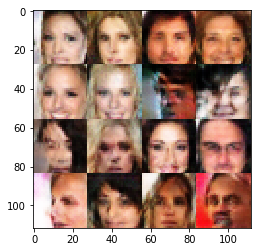

Epoch 4/4   Discriminator Loss: 1.4203   Generator Loss: 0.5297
Epoch 4/4   Discriminator Loss: 1.7385   Generator Loss: 0.2510
Epoch 4/4   Discriminator Loss: 1.2549   Generator Loss: 0.6162
Epoch 4/4   Discriminator Loss: 1.3864   Generator Loss: 0.7257
Epoch 4/4   Discriminator Loss: 1.4482   Generator Loss: 0.5468
Epoch 4/4   Discriminator Loss: 1.0792   Generator Loss: 0.6405
Epoch 4/4   Discriminator Loss: 1.3086   Generator Loss: 0.6324
Epoch 4/4   Discriminator Loss: 1.9384   Generator Loss: 0.2151
Epoch 4/4   Discriminator Loss: 1.2911   Generator Loss: 0.6036
Epoch 4/4   Discriminator Loss: 1.4663   Generator Loss: 0.4442
Epoch 4/4   Discriminator Loss: 1.6086   Generator Loss: 0.2987
Epoch 4/4   Discriminator Loss: 1.3942   Generator Loss: 0.5186
Epoch 4/4   Discriminator Loss: 1.7029   Generator Loss: 0.2738
Epoch 4/4   Discriminator Loss: 1.3146   Generator Loss: 0.5688
Epoch 4/4   Discriminator Loss: 1.4380   Generator Loss: 0.6724
Epoch 4/4   Discriminator Loss: 1.2000  

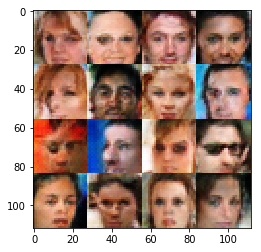

Epoch 4/4   Discriminator Loss: 1.2123   Generator Loss: 0.6087
Epoch 4/4   Discriminator Loss: 1.4216   Generator Loss: 0.3621
Epoch 4/4   Discriminator Loss: 1.4836   Generator Loss: 0.4228
Epoch 4/4   Discriminator Loss: 1.4374   Generator Loss: 0.5363
Epoch 4/4   Discriminator Loss: 1.4452   Generator Loss: 0.6041
Epoch 4/4   Discriminator Loss: 1.3211   Generator Loss: 0.5374
Epoch 4/4   Discriminator Loss: 1.4202   Generator Loss: 0.4254
Epoch 4/4   Discriminator Loss: 1.4510   Generator Loss: 0.3871
Epoch 4/4   Discriminator Loss: 1.3001   Generator Loss: 0.5671
Epoch 4/4   Discriminator Loss: 1.3883   Generator Loss: 0.4776
Epoch 4/4   Discriminator Loss: 1.4920   Generator Loss: 0.3722
Epoch 4/4   Discriminator Loss: 1.6408   Generator Loss: 0.3952
Epoch 4/4   Discriminator Loss: 1.4857   Generator Loss: 0.4869
Epoch 4/4   Discriminator Loss: 1.3762   Generator Loss: 0.5517
Epoch 4/4   Discriminator Loss: 1.4403   Generator Loss: 0.3895
Epoch 4/4   Discriminator Loss: 1.3449  

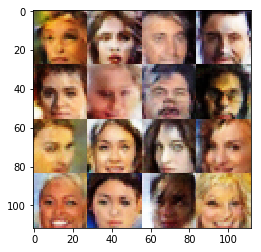

Epoch 4/4   Discriminator Loss: 1.5042   Generator Loss: 0.4102
Epoch 4/4   Discriminator Loss: 1.3935   Generator Loss: 0.9005
Epoch 4/4   Discriminator Loss: 1.5233   Generator Loss: 0.4507
Epoch 4/4   Discriminator Loss: 1.5622   Generator Loss: 0.3558
Epoch 4/4   Discriminator Loss: 1.7703   Generator Loss: 0.2583
Epoch 4/4   Discriminator Loss: 1.3826   Generator Loss: 0.4668
Epoch 4/4   Discriminator Loss: 1.3549   Generator Loss: 0.7093
Epoch 4/4   Discriminator Loss: 1.3470   Generator Loss: 0.4487
Epoch 4/4   Discriminator Loss: 1.4565   Generator Loss: 0.5802
Epoch 4/4   Discriminator Loss: 1.4103   Generator Loss: 0.5032
Epoch 4/4   Discriminator Loss: 1.3439   Generator Loss: 0.6372
Epoch 4/4   Discriminator Loss: 1.5696   Generator Loss: 0.4221
Epoch 4/4   Discriminator Loss: 1.3519   Generator Loss: 0.5729
Epoch 4/4   Discriminator Loss: 1.5487   Generator Loss: 0.3926
Epoch 4/4   Discriminator Loss: 1.4175   Generator Loss: 0.4833
Epoch 4/4   Discriminator Loss: 1.5763  

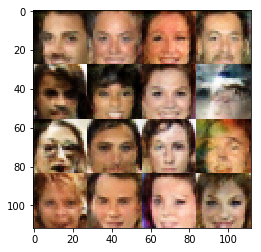

Epoch 4/4   Discriminator Loss: 1.3363   Generator Loss: 0.5375
Epoch 4/4   Discriminator Loss: 1.5391   Generator Loss: 0.5609
Epoch 4/4   Discriminator Loss: 1.8661   Generator Loss: 0.2147
Epoch 4/4   Discriminator Loss: 1.3555   Generator Loss: 0.5126
Epoch 4/4   Discriminator Loss: 1.4110   Generator Loss: 0.4344
Epoch 4/4   Discriminator Loss: 1.2551   Generator Loss: 0.5733
Epoch 4/4   Discriminator Loss: 1.4661   Generator Loss: 0.4203
Epoch 4/4   Discriminator Loss: 1.2497   Generator Loss: 0.6728
Epoch 4/4   Discriminator Loss: 1.3860   Generator Loss: 0.6240
Epoch 4/4   Discriminator Loss: 1.4253   Generator Loss: 0.4263
Epoch 4/4   Discriminator Loss: 1.4796   Generator Loss: 0.6887
Epoch 4/4   Discriminator Loss: 1.3432   Generator Loss: 0.5604
Epoch 4/4   Discriminator Loss: 1.5539   Generator Loss: 0.3470
Epoch 4/4   Discriminator Loss: 1.2448   Generator Loss: 0.8058
Epoch 4/4   Discriminator Loss: 1.3951   Generator Loss: 0.5810
Epoch 4/4   Discriminator Loss: 1.3861  

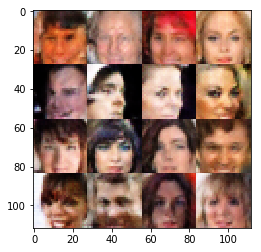

Epoch 4/4   Discriminator Loss: 1.2575   Generator Loss: 0.7940
Epoch 4/4   Discriminator Loss: 1.3126   Generator Loss: 0.5895


In [97]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

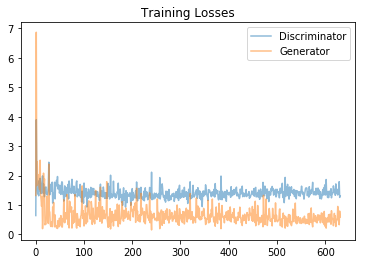

In [98]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.